In [113]:
import os
import math        
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import random

C_train = []
X_train = []
for i in range(20):
    x = random.random()/4
    y = random.random()
    r = 0.1 + random.random()/10
    
    x1 = 0.75 + random.random()/4
    y1 = random.random()
    r1 = 0.1 + random.random()/10
    
    for t in range(100):
        theta = 2*math.pi*t/100
        tx = x + r*math.cos(theta)
        ty = y + r*math.sin(theta)
        
        tx1 = x1 + r1*math.cos(theta)
        ty1 = y1 + r1*math.sin(theta)
        
        C_train.append([x,y,r,x1,y1,r1])
        X_train.append([tx, ty])
        
        C_train.append([x,y,r,x1,y1,r1])
        X_train.append([tx1, ty1])
    
    theta = math.atan2(y1-y, x1-x)
    xt = x + r*math.cos(theta)
    yt = y + r*math.sin(theta)
    
    xt1 = x1 - r1*math.cos(theta)
    yt1 = y1 - r1*math.sin(theta)
    for j in range(5):
        tx_ = xt + j/5*(xt1-xt)
        ty_ = yt + j/5*(yt1-yt)
        C_train.append([x,y,r,x1,y1,r1])
        X_train.append([tx_, ty_])

In [114]:
C_train = np.array(C_train)
X_train = np.array(X_train)

print("C.shape = ", C_train.shape)
print("X.shape = ", X_train.shape)

('C.shape = ', (4100, 6))
('X.shape = ', (4100, 2))


In [115]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

# neural network parameters
mb_size = 256
h_Q_dim = 512
h_P_dim = 512

c = 0
# learning rate
lr = 1e-4

# problem dimensions
dim = 2
dataElements = dim + 6 # sample (2D), cond(6)

z_dim = 2 # latent
X_dim = dim # samples
y_dim = dim # reconstruction of the original point
c_dim = dataElements - dim # dimension of conditioning variable

In [116]:
# define networks
print("X_dim = ",X_dim)
print("c_dim = ",c_dim)
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=[None, X_dim])
c = tf.placeholder(tf.float32, shape=[None, c_dim])
    
# Q
inputs_Q = tf.concat(axis=1, values=[X,c])

dense_Q1 = tf.layers.dense(inputs=inputs_Q, units=h_Q_dim, activation=tf.nn.relu)
dropout_Q1 = tf.layers.dropout(inputs=dense_Q1, rate=0.5)
dense_Q2 = tf.layers.dense(inputs=dropout_Q1, units=h_Q_dim, activation=tf.nn.relu)

z_mu = tf.layers.dense(inputs=dense_Q2, units=z_dim) # output here is z_mu
z_logvar = tf.layers.dense(inputs=dense_Q2, units=z_dim) # output here is z_logvar

# P
eps = tf.random_normal(shape=tf.shape(z_mu))
z = z_mu + tf.exp(z_logvar / 2) * eps
inputs_P = tf.concat(axis=1, values=[z,c])
# print("path = ",path_)
numTrain = X.shape[0]
dense_P1 = tf.layers.dense(inputs=inputs_P, units=h_P_dim, activation=tf.nn.relu)
dropout_P1 = tf.layers.dropout(inputs=dense_P1, rate=0.5)
dense_P2 = tf.layers.dense(inputs=dropout_P1, units=h_P_dim, activation=tf.nn.relu)

y = tf.layers.dense(inputs=dense_P2, units=X_dim) # fix to also output y

# training
########### comment in the one with 0 weight and uncomment the other ###########
w = [[1, 1]];
# w = [[1, 1, 1, 0, 0, 0]];
recon_loss = tf.losses.mean_squared_error(labels=X, predictions=y, weights=w)

# TODO: fix loss function for angles going around
kl_loss = 10**-4 * 2 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)

cvae_loss = tf.reduce_mean(kl_loss + recon_loss)

train_step = tf.train.AdamOptimizer(lr).minimize(cvae_loss)

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
it = 0;

('X_dim = ', 2)
('c_dim = ', 6)


In [117]:
numTrain = X_train.shape[0]
print(X_train.shape)
print("numTrain = ", numTrain)

(4100, 2)
('numTrain = ', 4100)


In [118]:
saver = tf.train.Saver()
path_ = os.getcwd() + "/checkpoints_test/model.ckpt"

print("numTrain = ",numTrain)
try:
    saver.restore(sess, path_)
    print("Model Restored!!")
except Exception as e:
    print("Could not restore checkpoint!")
    print(e)
x1 = []
y1 = []    
for it in range(it,it+600001):
#     print("c_dim = ",c_dim)
    # randomly generate batches
    batch_elements = [random.randint(0,numTrain-1) for n in range(0,mb_size)]
    X_mb = X_train[batch_elements,:]
    c_mb = C_train[batch_elements,:]

    _, loss, r = sess.run([train_step, cvae_loss, recon_loss], feed_dict={X: X_train, c: C_train})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        x1.append(it)
        y1.append(loss)
        print("recon_loss = ", r)
    if it % 1000 == 0:    
        saver.save(sess, path_)
        print("saved session to ", path_)

('numTrain = ', 4100)
INFO:tensorflow:Restoring parameters from /home/vernwalrahul/projects/Workspace_halton_2d/checkpoints_test/model.ckpt
Model Restored!!
Iter: 0
Loss: 0.002444
('recon_loss = ', 0.0009545511)
('saved session to ', '/home/vernwalrahul/projects/Workspace_halton_2d/checkpoints_test/model.ckpt')
Iter: 1000
Loss: 0.001786
('recon_loss = ', 0.00033033532)
('saved session to ', '/home/vernwalrahul/projects/Workspace_halton_2d/checkpoints_test/model.ckpt')
Iter: 2000
Loss: 0.001764
('recon_loss = ', 0.00031009177)
('saved session to ', '/home/vernwalrahul/projects/Workspace_halton_2d/checkpoints_test/model.ckpt')
Iter: 3000
Loss: 0.001771
('recon_loss = ', 0.0003182469)
('saved session to ', '/home/vernwalrahul/projects/Workspace_halton_2d/checkpoints_test/model.ckpt')
Iter: 4000
Loss: 0.001758
('recon_loss = ', 0.00030993897)
('saved session to ', '/home/vernwalrahul/projects/Workspace_halton_2d/checkpoints_test/model.ckpt')


KeyboardInterrupt: 

('c_sample = ', array([0.0065568 , 0.300955  , 0.17508802, 0.93038758, 0.11702793,
       0.19671666]))


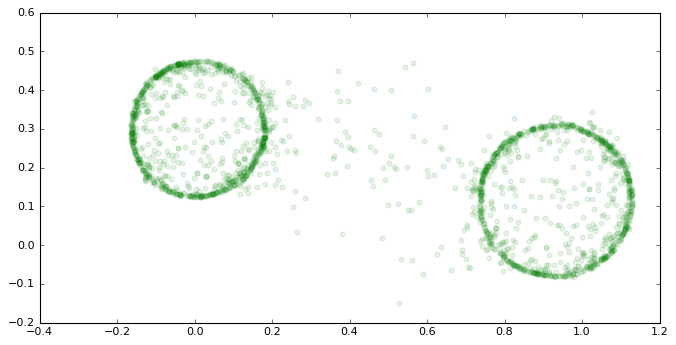

In [143]:
test_case = random.randint(0, numTrain-1)
c_sample_seed = C_train[test_case,:]

num_viz = 2000

c_sample = np.repeat([c_sample_seed],num_viz,axis=0)
y_viz, z_viz = sess.run([y, z], feed_dict={z: np.random.randn(num_viz, z_dim), c: c_sample})

fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect='equal')

print("c_sample = ", c_sample_seed)

plt.scatter(y_viz[:,0],y_viz[:,1], color="green", s=20, alpha = 0.1)
circle1 = plt.Circle((c_sample_seed[0], c_sample_seed[1]), c_sample_seed[2], color = 'b', fill = False)
circle2 = plt.Circle((c_sample_seed[3], c_sample_seed[4]), c_sample_seed[5], color = 'b', fill = False)
# ax1.add_artist(circle1)
# ax1.add_artist(circle2)

# plt.xlim(-1,2)
# plt.ylim(-1,2)
plt.show()